# Jam Session XIII: Natural Language Processing

This Jam Session focuses on text analysis and various methods that can be used to tokenize, and analyze data. This Jam Session has been divided into 3 parts:
    
    1. Tokenization of Text
    2. Text Classification using Naïve Bayes
    3. Text Classification using Bag of Words Model and Neural Nets

The models used in this session take in data from a text file. The data used in this flie was taken from https://github.com/jennacryan/NBC

This notebook will go through how the data was loaded, how it was processed and how Naïve Bayes and a Bag of Words Model were used to allow for text classificaion.

The data set contains reviews of various movies taken of IMDb. I am aiming to look at a review and look at the context and the words used in the review to determine whether a positive or a negativve review was given for the movie.

Insipration for this Jam Session 13 comes from Jam Session 10 in which Daniel Palacios (daniel.m.palacious@nasa.gov) created BERT for text analytics. I wished to find my own methods/ another method for text classificaion.

For any questions or suggestions regarding this Jam Session please contact Nevin Aresh (nevin.aresh@nasa.gov).

In [29]:
#Import modules required for Project
import sys
import os
import nltk
from nltk import word_tokenize
nltk.download('punkt')
import torch

#Sparse matrix implementation
from scipy.sparse import csr_matrix
import numpy as np
from collections import Counter

import tqdm
import torch.nn as nn
from torch import optim
import random
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
#Download the data

!wget https://github.com/aritter/5525_sentiment/raw/master/aclImdb_small.tgz
!tar xvzf aclImdb_small.tgz > /dev/null

--2021-12-03 06:18:58--  https://github.com/aritter/5525_sentiment/raw/master/aclImdb_small.tgz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aritter/5525_sentiment/master/aclImdb_small.tgz [following]
--2021-12-03 06:18:59--  https://raw.githubusercontent.com/aritter/5525_sentiment/master/aclImdb_small.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9635749 (9.2M) [application/octet-stream]
Saving to: ‘aclImdb_small.tgz.3’

aclImdb_small.tgz.3 100%[===================>]   9.19M  --.-KB/s    in 0.06s   

2021-12-03 06:18:59 (146 MB/s) - ‘aclImdb_small.tgz.3’ saved [9635749/9635749]



## Tokenization of Data

In this section, we are attempting to tokenize the data by assigning each word in the file a particular number. By doing so, it allows for easier analysis in the other sections of this Jam Session where we implement the algorithmms. First, we take in and read the text files and analyze them line by line, assigning each word a number. We then store this in a sparse array. I chose to use a sparse array since it allows for a smaller data struture when using the data for the algorithms.

In [31]:
np.random.seed(1)

class Vocab:
    #goes line by line in the file and assigns each word an Id
    def __init__(self, vocabFile=None):
        self.locked = False
        self.nextId = 0
        self.word2id = {}
        self.id2word = {}
        if vocabFile:
            for line in open(vocabFile):
                line = line.rstrip('\n')
                (word, wid) = line.split('\t')
                self.word2id[word] = int(wid)
                self.id2word[wid] = word
                self.nextId = max(self.nextId, int(wid) + 1)

    def GetID(self, word):
        if not word in self.word2id:
            if self.locked:
                return -1 
            else:
                self.word2id[word] = self.nextId
                self.id2word[self.word2id[word]] = word
                self.nextId += 1
        return self.word2id[word]

    def HasWord(self, word):
        return self.word2id.has_key(word)

    def HasId(self, wid):
        return self.id2word.has_key(wid)

    def GetWord(self, wid):
        return self.id2word[wid]

    def SaveVocab(self, vocabFile):
        fOut = open(vocabFile, 'w')
        for word in self.word2id.keys():
            fOut.write("%s\t%s\n" % (word, self.word2id[word]))

    def GetVocabSize(self):
        return self.nextId

    def GetWords(self):
        return self.word2id.keys()

    def Lock(self):
        self.locked = True

class IMDBdata:
    def __init__(self, directory, vocab=None):
        # Reads in data into sparse matrix format
        posFiles = os.listdir("%s/pos" % directory)
        negFiles = os.listdir("%s/neg" % directory)

        if not vocab:
            self.vocab = Vocab()
        else:
            self.vocab = vocab

        #the sparse arrays into which all the data is added
        X_values = []
        X_row_indices = []
        X_col_indices = []
        Y = []

        XwordList = []
        XfileList = []

        #Read and categorize positive files
        for i in range(len(posFiles)):
            f = posFiles[i]
            for line in open("%s/pos/%s" % (directory, f)):
                wordList   = [self.vocab.GetID(w.lower()) for w in word_tokenize(line) if self.vocab.GetID(w.lower()) >= 0]
                XwordList.append(wordList)
                XfileList.append(f)
                wordCounts = Counter(wordList)
                for (wordId, count) in wordCounts.items():
                    if wordId >= 0:
                        X_row_indices.append(i)
                        X_col_indices.append(wordId)
                        X_values.append(count)
            Y.append(+1.0)

        #Read and categorize negative files
        for i in range(len(negFiles)):
            f = negFiles[i]
            for line in open("%s/neg/%s" % (directory, f)):
                wordList   = [self.vocab.GetID(w.lower()) for w in word_tokenize(line) if self.vocab.GetID(w.lower()) >= 0]
                XwordList.append(wordList)
                XfileList.append(f)
                wordCounts = Counter(wordList)
                for (wordId, count) in wordCounts.items():
                    if wordId >= 0:
                        X_row_indices.append(len(posFiles)+i)
                        X_col_indices.append(wordId)
                        X_values.append(count)
            Y.append(-1.0)
            
        self.vocab.Lock()

        #Create a sparse matrix in csr format
        self.X = csr_matrix((X_values, (X_row_indices, X_col_indices)), shape=(max(X_row_indices)+1, self.vocab.GetVocabSize()))
        self.Y = np.asarray(Y)

        #Randomly shuffle
        index = np.arange(self.X.shape[0])
        np.random.shuffle(index)
        self.X = self.X[index,:]
        self.XwordList = [torch.LongTensor(XwordList[i]) for i in index]  #Two different sparse formats, csr and lists of IDs (XwordList).
        self.XfileList = [XfileList[i] for i in index]
        self.Y = self.Y[index]

## Reading in the Data
When reading in the data from the files, we pass it into the IMDBdata class. After it is passed into this class, the data is tokenized and each work is assigned a number. Afterwards, the tokenized number for the data is passed into a spartse array. By passing it into a sparse array, we are able to save data as there are many rows/columns with a tokenization of 0.

In [32]:
#read in the train, development and test data
train = IMDBdata("aclImdb_small/train")
train.vocab.Lock()
dev  = IMDBdata("aclImdb_small/dev", vocab=train.vocab)
test  = IMDBdata("aclImdb_small/test", vocab=train.vocab)

### Properties of the Data
We can see the data size/ structure of the train data set as well as how the data is actually stored into the sparse array by seeing how the tokenized data is stored as well as the row and column it belongs to. The second cell shows the calculations that we use for calculation Stochastic Gradient Descent for the Naïve Bayes algorithm.

In [33]:
#output the size of the data
print(f"Train.X has {train.X.shape[0]} rows and {train.X.shape[1]} columns.")
print (train.X)

Train.X has 7222 rows and 58162 columns.
  (0, 1)	3
  (0, 3)	1
  (0, 5)	2
  (0, 8)	1
  (0, 11)	15
  (0, 13)	1
  (0, 14)	4
  (0, 15)	4
  (0, 18)	4
  (0, 20)	4
  (0, 21)	4
  (0, 22)	4
  (0, 23)	4
  (0, 24)	1
  (0, 26)	3
  (0, 27)	10
  (0, 38)	8
  (0, 39)	1
  (0, 41)	1
  (0, 47)	4
  (0, 52)	1
  (0, 61)	5
  (0, 96)	1
  (0, 111)	1
  (0, 119)	1
  :	:
  (7221, 5772)	2
  (7221, 6448)	1
  (7221, 6483)	1
  (7221, 7461)	1
  (7221, 9692)	1
  (7221, 9956)	1
  (7221, 15304)	2
  (7221, 15612)	1
  (7221, 15942)	2
  (7221, 16103)	1
  (7221, 16911)	2
  (7221, 21363)	1
  (7221, 25393)	1
  (7221, 26036)	1
  (7221, 27067)	1
  (7221, 28138)	1
  (7221, 29031)	1
  (7221, 29039)	3
  (7221, 31018)	1
  (7221, 40830)	1
  (7221, 44393)	1
  (7221, 47593)	1
  (7221, 48770)	3
  (7221, 48771)	1
  (7221, 48772)	1


In [34]:
#output the calculations used in the Naïve Bayes section in the next part
word_counts_neg = np.array(train.X[train.Y == -1,:].sum(axis=0)).flatten()
word_counts_pos = np.array(train.X[train.Y == 1,:].sum(axis=0)).flatten()
pos_liklihood = np.log((word_counts_pos+1.0)/(sum(word_counts_pos)+1.0))
neg_liklihood = np.log((word_counts_neg+1.0)/(sum(word_counts_neg)+1.0))
print("The log", pos_liklihood)
print(neg_liklihood)

The log [ -7.32527589  -5.74396715  -5.46057354 ... -13.85469473 -13.85469473
 -13.85469473]
[ -7.3333442   -5.86261778  -5.44025086 ... -13.11254332 -13.11254332
 -13.11254332]


## Naïve Bayes
This section is uses Naïve Bayes to use the tokenized to calculate the probability of the given movie review being positive or negative. We use the log likelihoods as well as log priors to calculate. 
Below we can see the formula for the Naïve Bayes Algorithm:

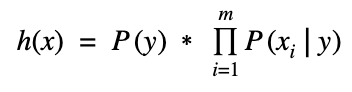

By taking the natural log of this equation, we are able to come up with the log equation for the Naïve Bayes formula. By using this formula, we are able to prevent underflow in our calculations and it allows for a more accurate calutions. This is the result we get when we take the log of the Naïve Bayes formula:

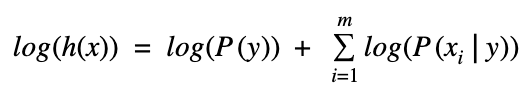

The final cell in this section shows the accuracy we get from running my Naïve Bayes algorithm on the test data set.

In [36]:
class Eval:
    def __init__(self, pred, gold):
        self.pred = pred
        self.gold = gold
        
    def Accuracy(self):
        return np.sum(np.equal(self.pred, self.gold)) / float(len(self.gold))

class NaiveBayes:
    #initialize the data, the prior, the log likelihood as well as the calcularions needed to calculate
    #SGD in the Train and Predict portion of the code
    def __init__(self, X, Y, ALPHA=1.0):
        self.X = X
        self.Y = Y
        self.prior = {}
        self.likelihood = {}
        self.alpha = ALPHA
        self.Train(X,Y)

    def Train(self, X, Y):
        #calculate the log priors for the positive and negative data sets
        self.prior['pos'] = np.log(sum(1 for label in Y if label == 1) / (Y.size))
        self.prior['neg'] = np.log(sum(1 for label in Y if label == -1) / (Y.size))
        word_counts_neg = np.array(X[Y == -1,:].sum(axis=0)).flatten()
        word_counts_pos = np.array(X[Y == 1,:].sum(axis=0)).flatten()
        #calculate the log likelihoods of the positive and negative data sets
        self.likelihood['pos'] = np.log((word_counts_pos+self.alpha)/(sum(word_counts_pos)+self.alpha))
        self.likelihood['neg'] = np.log((word_counts_neg+self.alpha)/(sum(word_counts_neg)+self.alpha))
        return

    def Predict(self, X):
        #the array that characterizes whether the given review is a positive one using our code
        result = []
        for x in X:
          posprob = self.prior['pos']
          negprob = self.prior['neg']
          posprob = posprob + sum(self.likelihood['pos'][x.indices])
          negprob = negprob + sum(self.likelihood['neg'][x.indices])
          #determines whether the text has a higher chance of being positive or negative
          if (posprob > negprob):
            result.append(1)
          else:
            result.append(-1)
        return result

    #used to evaluate whether how acccurately we can predict with the test data set
    #after we have finished training the model 
    def Eval(self, X_test, Y_test):
        Y_pred = self.Predict(X_test)
        ev = Eval(Y_pred, Y_test)
        return ev.Accuracy()

In [37]:
#calculate Naïve Bayes and print the accuracy for the test set
print("Evaluate on the test set:")
nb = NaiveBayes(train.X, train.Y, 1.0)
print(nb.Eval(test.X, test.Y))

Evaluate on the test set:
0.8150096926059264


## Bag of Words Using Neural Networks
For my implementation of this model, I am following the Bag of Words model as described in this [research paper](https://aclanthology.org/P15-1162.pdf).

For my implementation of this model, I used an embedding layer, a ReLU layer, a linear layer, and a Softmax layer. In addition, I use an Adam Optimizer to help with Stochastic Gradient Descent Calculations. The NBOW method is used to create the Neural Bag of Words model and allows for me to define the forward pass of the data.

The calculated data from the forward pass is udes in the train method to compute the gradients and update the loss. For the loss calculation, a cross-entropy hinge loss was used. Although pytorch does have it's own implementation of the cross-entropy loss, I coded the loss formula by hand to demonstrate exactly what does into calculting the cross entropy loss.

After training the data, the second cell in this section is used to run and evaluate how effective the bag of words model is as well as the accuracy.

In [40]:
class NBOW(nn.Module):
    def __init__(self, VOCAB_SIZE, DIM_EMB=300, NUM_CLASSES=2):
        super(NBOW, self).__init__()
        self.NUM_CLASSES=NUM_CLASSES
        self.V = nn.Embedding(VOCAB_SIZE, DIM_EMB).cuda()
        self.g = nn.ReLU().cuda()
        self.W = nn.Linear(DIM_EMB, NUM_CLASSES).cuda()
        self.logSoftmax = nn.LogSoftmax(dim=0).cuda()

    def forward(self, X):
        return self.logSoftmax(self.W(self.g(torch.mean(self.V(X.cuda()),0))))

def EvalNet(data, net):
    num_correct = 0
    Y = (data.Y + 1.0) / 2.0
    X = data.XwordList
    for i in range(len(X)):
        logProbs = net.forward(X[i])
        pred = torch.argmax(logProbs)
        if pred == Y[i]:
            num_correct += 1
    print("Accuracy: %s" % (float(num_correct) / float(len(X))))

def SavePredictions(data, outFile, net):
    fOut = open(outFile, 'w')
    for i in range(len(data.XwordList)):
        logProbs = net.forward(data.XwordList[i])
        pred = torch.argmax(logProbs)
        fOut.write(f"{data.XfileList[i]}\t{pred}\n")

def Train(net, X, Y, n_iter, dev):
    print("Start Training!")
    #TODO: initialize optimizer.
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    num_classes = len(set(Y))

    for epoch in range(n_iter):
        num_correct = 0
        total_loss = 0.0
        net.train()   #Put the network into training mode
        for i in tqdm.notebook.tqdm(range(len(X))):
            #compute gradients and update loss
            net.zero_grad()
            optimizer.zero_grad()
            
            logProbs = net.forward(X[i].cuda())
            y_onehot = torch.zeros(2).cuda()
            y_onehot[Y.astype(np.int)[i]] = 1
            loss = torch.neg(logProbs).dot(y_onehot.cuda())
            total_loss += loss
            loss.backward()
            optimizer.step()

        net.eval()    #Switch to eval mode
        print(f"loss on epoch {epoch} = {total_loss}")
        EvalNet(dev, net)

nbow = NBOW(train.vocab.GetVocabSize()).cuda()
Train(nbow, train.XwordList, (train.Y + 1.0) / 2.0, 10, dev)

Start Training!


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 0 = 2469.101806640625
Accuracy: 0.86003600360036


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 1 = 385.9703674316406
Accuracy: 0.8154815481548154


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 2 = 91.10072326660156
Accuracy: 0.8429342934293429


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 3 = 62.70149230957031
Accuracy: 0.8357335733573358


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 4 = 52.42148208618164
Accuracy: 0.8433843384338434


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 5 = 30.90900421142578
Accuracy: 0.8478847884788479


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 6 = 0.05431332439184189
Accuracy: 0.8483348334833484


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 7 = 0.00034044525818899274
Accuracy: 0.8496849684968497


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 8 = 1.5497204003622755e-05
Accuracy: 0.8501350135013501


  0%|          | 0/7222 [00:00<?, ?it/s]

loss on epoch 9 = 3.576278402306343e-07
Accuracy: 0.851935193519352


In [39]:
# evaluate the accuracy of the NBOW method on the 
print("Evaluate on the test set:")
EvalNet(test, nbow)

Evaluate on the test set:
Accuracy: 0.8431182497923013
